# EfficientNetB0 Model

EfficientNet is a family of convolutional neural network architectures that have achieved state-of-the-art performance across various image classification tasks while maintaining efficiency in terms of computational resources. EfficientNetB0 is the base model in this family, and it serves as the baseline for other variants such as EfficientNetB1, B2, B3, etc., which progressively increase in depth, width, and resolution.

For this I wanted to see how an "out of the box" pretained model would work.

## import all necessary libraries, modules etc


In [ ]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import re
import os
import random
import tensorflow as tf
import plotly.express as px
import h5py

from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, \
    precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from PIL import Image
from scipy.stats import skew
from tqdm import tqdm

### I keep running into issues with the GPU, namely tensorflow doesn’t support windows native so I have to use an older version of tensorflow. Thus I check to make sure that tensorflow is able to access the gpu.

In [2]:
print("tensorflow version: ", tf.__version__)
print("number of GPU's available", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tensorflow version:  2.10.0
number of GPU's available 1


# 1 Import and Pre-process Data

In [3]:
file_path = 'Data/oasis_data'
# List all items in data_path and filter out '.DS_Store' and any other non-directory items
classes = [item for item in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, item)) and item != '.DS_Store']
print(classes)

['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [4]:
# Map directory names to lists
categories = {
    'Non Demented': [],
    'Very mild Dementia': [],
    'Mild Dementia': [],
    'Moderate Dementia': []
}

image_extensions = '.jpg'  # Image extensions

base_dir = 'Data/oasis_data/'

# Loop through each category
for category in categories.keys():
    dir_path = os.path.join(base_dir, category)
    for dirname, _, filenames in os.walk(dir_path):
        for filename in filenames:
            if os.path.splitext(filename)[1].lower() in image_extensions:
                categories[category].append(os.path.join(dirname, filename))

# lists of the directories
non_demented = categories['Non Demented']
very_mild_demented = categories['Very mild Dementia']
mild_demented = categories['Mild Dementia']
moderate_demented = categories['Moderate Dementia']


In [5]:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

67222
13725
5002
488


# Set random seed for reproducablity, and split off traning and testing data from both classes

In [6]:
# Set seed for random sampling
random.seed(42)

# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42
)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

very_mild_demented = random.sample(non_demented,2500)
# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

non_demented = random.sample(non_demented, 5000)
# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

In [7]:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

5000
2500
5002
488


In [8]:
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

4000
2000
4001
390


In [9]:
# One-hot encoder for class labels
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]]) 

OneHotEncoder()

# Process the images. 
Here I processes images from two categories ('non_demented' and 'demented') by loading, resizing (I tried multiple sizing 124x124, 224x224 and final the original image size 498x248), and converting them into numpy arrays. The processed images and their labels are stored as numpy arrays.

In [10]:
from PIL import Image
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# Dictionary of categories
categories = {
    'non_demented': non_demented_train,
    'very_mild_demented': very_mild_demented_train,
    'mild_demented': mild_demented_train,
    'moderate_demented': moderate_demented_train
}


data = []
result = []

# Function to process and append data
def process_image(path, label_index):
    img = Image.open(path)
   #img = img.resize((224, 224))  # Correct order (width, height)
    img = np.array(img)
    data.append(img)
    #result.append(label_index)
    result.append(encoder.transform([[label_index]]).toarray())


# Loop through each category
for label_index, (category, paths) in enumerate(categories.items()):
    for path in paths:
        process_image(path, label_index)

# Convert lists to numpy arrays 
data = np.array(data)
result = np.array(result)

In [11]:
result = np.array(result)
result = result.reshape((data.shape[0],4)) 
result.shape

(10391, 4)

In [12]:
data.shape

(10391, 248, 496, 3)

In [13]:
# Dictionary of test categories 
test_categories = {
    'non_demented': non_demented_test,
    'very_mild_demented': very_mild_demented_test,
    'mild_demented': mild_demented_test,
    'moderate_demented': moderate_demented_test
}

# Empty lists to store the test data and the corresponding labels
data_test = []
result_test = []

# Function to process and append test data
def process_test_image(path, label_index):
    img = Image.open(path)
    #img = img.resize((224, 224))
    img = np.array(img)
    data_test.append(img)
    #result_test.append(label_index)
    result_test.append(encoder.transform([[label_index]]).toarray())

# Loop through each test category
for label_index, (category, paths) in enumerate(test_categories.items()):
    for path in paths:
        process_test_image(path, label_index)

# Optionally, convert lists to numpy arrays for consistency with training data
data_test = np.array(data_test)
result_test = np.array(result_test)

In [14]:
data_test = np.array(data_test)
data_test.shape

(2599, 248, 496, 3)

In [15]:
x_test = data_test
y_test = y_test.reshape((2599,4))
y_test.shape

NameError: name 'y_test' is not defined

#  train test split to split training set 

In [16]:
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

## Building the model
### This is a pretrained model that was trained using the imagenet dataset. Below I download the weights, and process them into the shape of the images I'm trianing. 

I tried adding custom layers to the model but that wsan't very helpful, it caused a lot of overfitting and the loss function would increase at high rates.'

In [17]:
pretrained_base_EfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(248, 496, 3))

pretrained_base_EfficientNetB0.trainable = True

model_EfficientNetB02 = models.Sequential([
    pretrained_base_EfficientNetB0,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation='softmax')
])

model_EfficientNetB02.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_EfficientNetB02.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 16, 1280)      4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [18]:
history = model_EfficientNetB02.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
260/260 [==============================] - 64s 205ms/step - loss: 0.6163 - accuracy: 0.7270 - val_loss: 1.5397 - val_accuracy: 0.4704
Epoch 2/30
260/260 [==============================] - 51s 195ms/step - loss: 0.4318 - accuracy: 0.7859 - val_loss: 0.4228 - val_accuracy: 0.7937
Epoch 3/30
260/260 [==============================] - 51s 198ms/step - loss: 0.4116 - accuracy: 0.7932 - val_loss: 0.4109 - val_accuracy: 0.7941
Epoch 4/30
260/260 [==============================] - 52s 199ms/step - loss: 0.4045 - accuracy: 0.7942 - val_loss: 0.5380 - val_accuracy: 0.7763
Epoch 5/30
260/260 [==============================] - 52s 199ms/step - loss: 0.3753 - accuracy: 0.8064 - val_loss: 0.4499 - val_accuracy: 0.7143
Epoch 6/30
260/260 [==============================] - 52s 199ms/step - loss: 0.3711 - accuracy: 0.8103 - val_loss: 0.4280 - val_accuracy: 0.7888
Epoch 7/30
260/260 [==============================] - 52s 198ms/step - loss: 0.3573 - accuracy: 0.8192 - val_loss: 0.6311 - val_ac

# Performance Metric such as test accuracy, F1, Recall, and Precision (they were all terrible) 

In [ ]:
result_test = np.array(result_test)

# Now, correctly initialize y_test using result_test
y_test = result_test.reshape((result_test.shape[0], 4))

# Now y_test should have the correct shape (2599, 4) to match x_test and can be used for model evaluation
test_loss, test_accuracy = model_EfficientNetB02.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

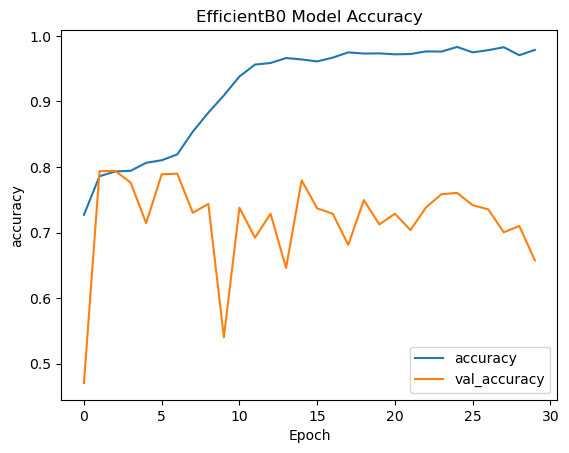

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('EfficientB0 Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()


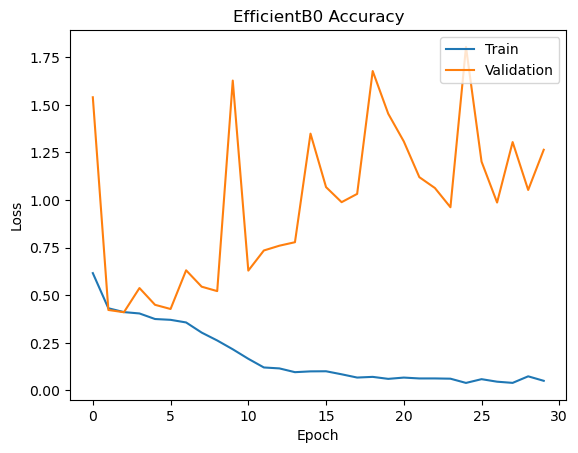

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('EfficientB0 Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [23]:
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on the test set
y_pred = model_EfficientNetB02.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


82/82 [==============================] - 4s 39ms/step
Precision: 0.7174
Recall: 0.6899
F1 Score: 0.7021


In [26]:
# List all the layers to check if Conv2D layers are present
for layer in model_EfficientNetB02.layers:
    print(layer.name, layer.output.shape)



efficientnetb0 (None, 8, 16, 1280)
global_average_pooling2d (None, 1280)
dense (None, 4)


# Extrating feature maps. 
This was more difficult than I anticipated. The model basically encapulates itself and I had to unwrap individual layers to extract image outputs of the feature map. Given the model was not good I didn't spend very much time here. 

Layer 0 activation stats: min=-13.983147621154785, max=14.582025527954102, mean=0.8186282515525818


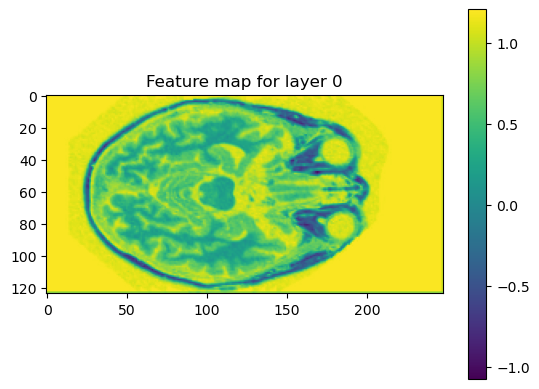

Layer 1 activation stats: min=-0.16621333360671997, max=-0.00037655080086551607, mean=-0.06688950955867767


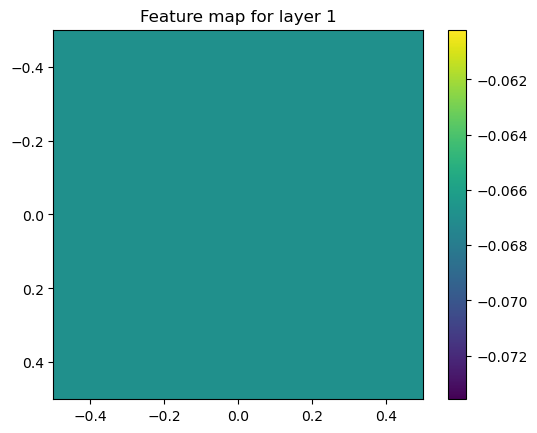

Layer 2 activation stats: min=0.16709400713443756, max=0.7121662497520447, mean=0.4644075632095337


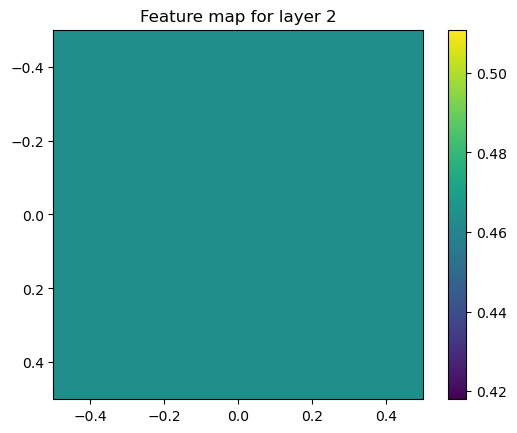

Layer 3 activation stats: min=-45.01606750488281, max=43.06269454956055, mean=0.6135073900222778


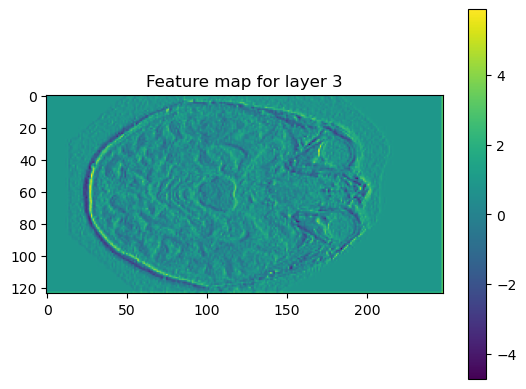

Layer 4 activation stats: min=-164.2366485595703, max=127.06402587890625, mean=-0.041799746453762054


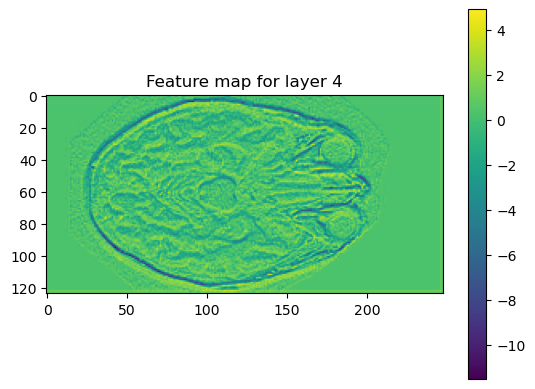

Layer 5 activation stats: min=-2.4585187929915264e-05, max=-1.5852479862132896e-07, mean=-1.138366678787861e-05


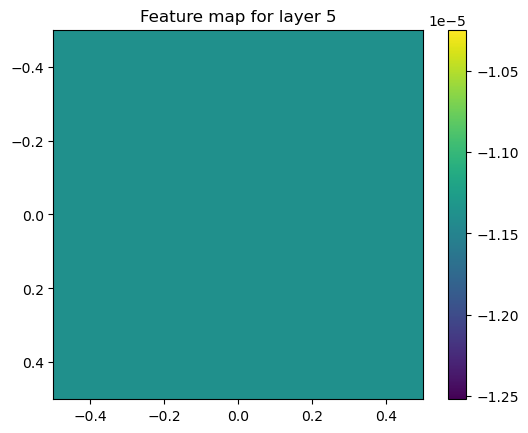

Layer 6 activation stats: min=0.3337741494178772, max=0.7314216494560242, mean=0.4878183901309967


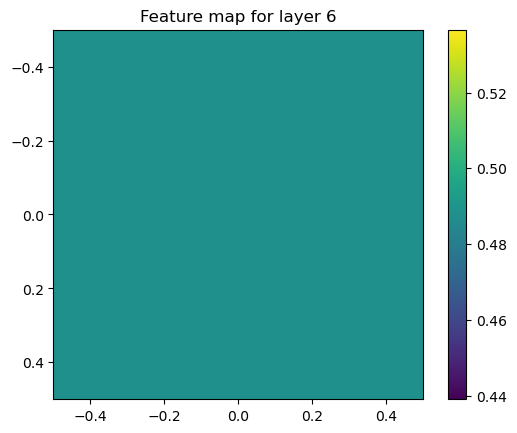

Layer 7 activation stats: min=-87.44013214111328, max=93.58406829833984, mean=1.9984595775604248


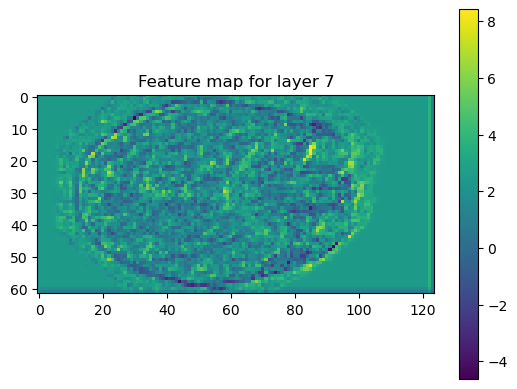

Layer 8 activation stats: min=-148.43031311035156, max=93.87205505371094, mean=-0.0050566233694553375


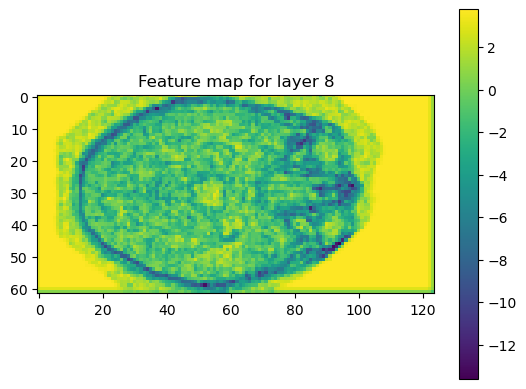

Layer 9 activation stats: min=-0.10089504718780518, max=5.191999912261963, mean=3.335852861404419


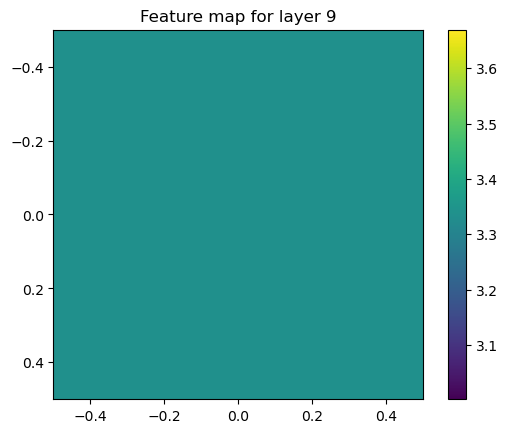

Layer 10 activation stats: min=0.00035441387444734573, max=0.9996901750564575, mean=0.69944828748703


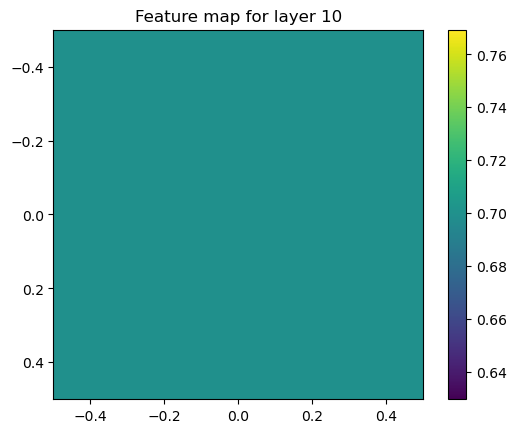

Layer 11 activation stats: min=-18.837223052978516, max=19.864734649658203, mean=-0.09152357280254364


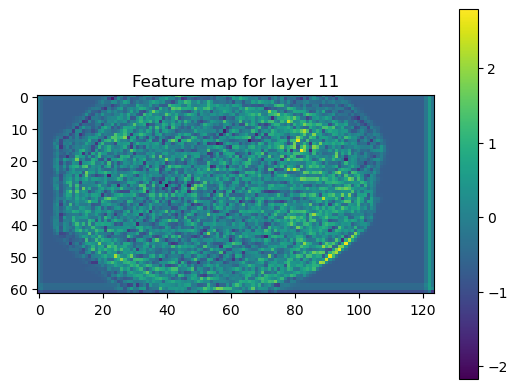

Layer 12 activation stats: min=-158.31346130371094, max=133.3642578125, mean=-1.390282392501831


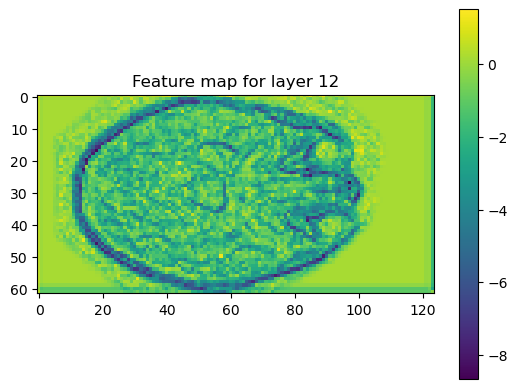

Layer 13 activation stats: min=-0.0005474604549817741, max=-3.2046282285591587e-06, mean=-0.0003120136971119791


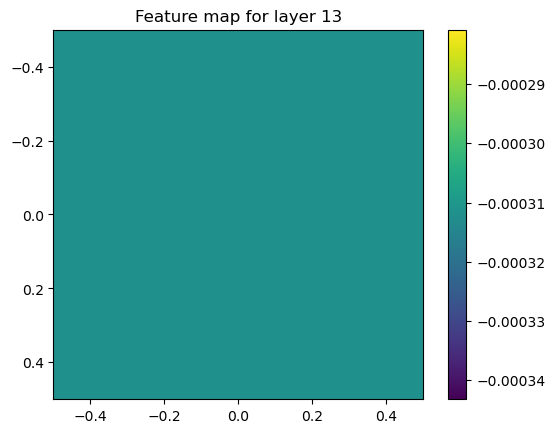

Layer 14 activation stats: min=0.2977912724018097, max=0.6766209602355957, mean=0.49645817279815674


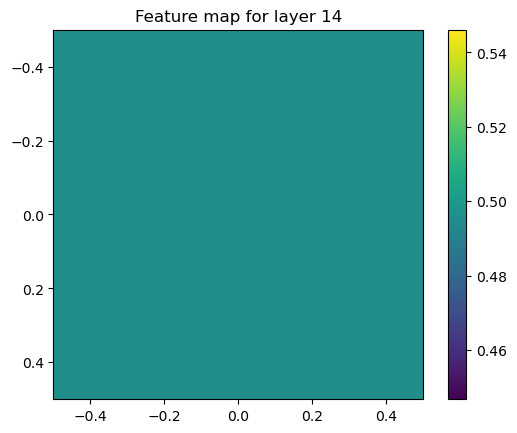

Layer 15 activation stats: min=-22.836196899414062, max=34.64112854003906, mean=-0.8169177174568176


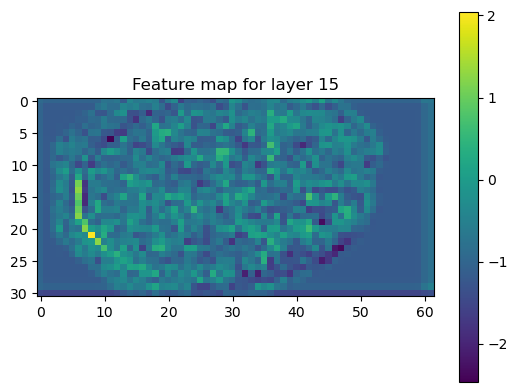

Layer 16 activation stats: min=-72.4521255493164, max=67.50234985351562, mean=-0.1532772034406662


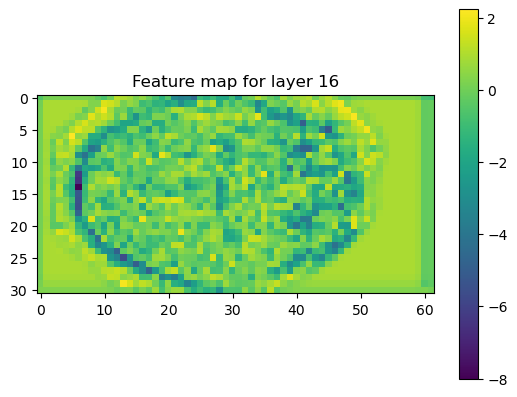

Layer 17 activation stats: min=-0.2702353298664093, max=3.778242588043213, mean=1.2734043598175049


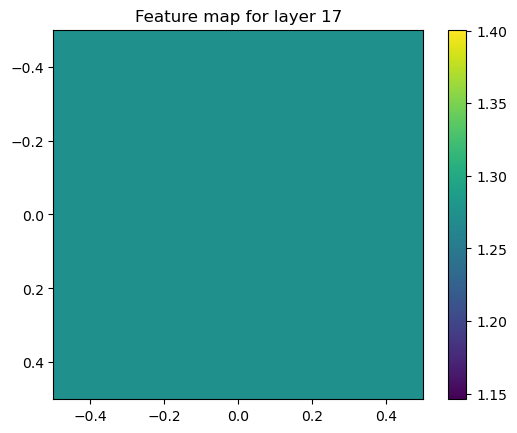

Layer 18 activation stats: min=0.007210603449493647, max=0.9883182644844055, mean=0.6098149418830872


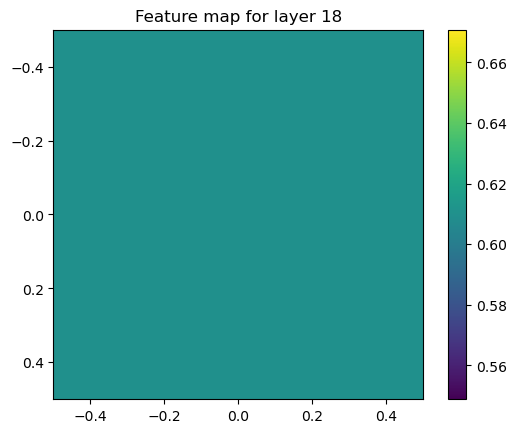

Layer 19 activation stats: min=-19.98542022705078, max=19.144113540649414, mean=0.04874539375305176


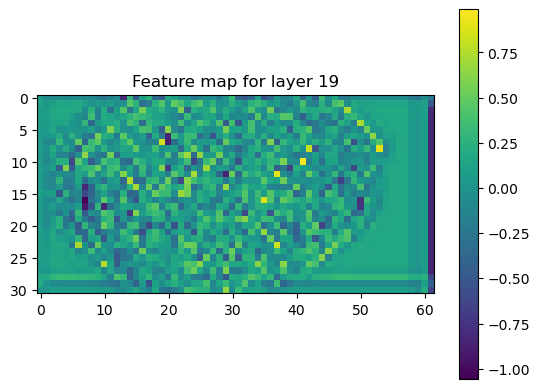

Layer 20 activation stats: min=-169.60142517089844, max=116.20348358154297, mean=-1.4241255521774292


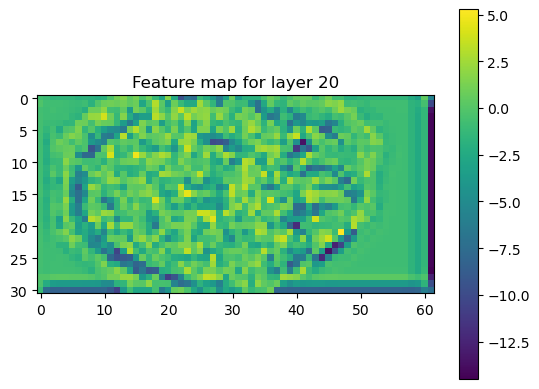

Layer 21 activation stats: min=-0.002025074325501919, max=-1.7899657223097165e-06, mean=-0.0005089676124043763


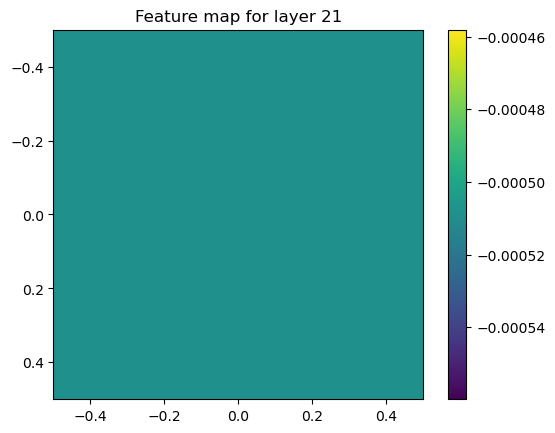

Layer 22 activation stats: min=0.38839420676231384, max=0.6244469285011292, mean=0.4993535876274109


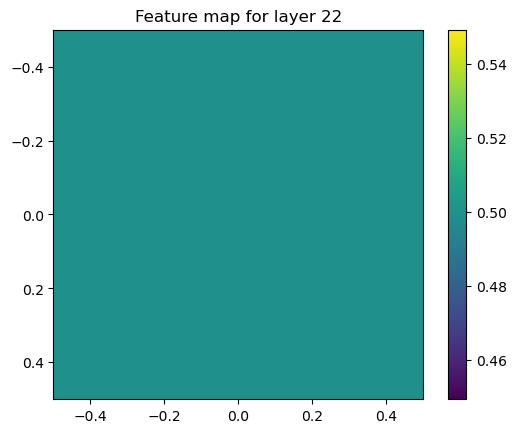

Layer 23 activation stats: min=-17.516357421875, max=16.11415672302246, mean=-0.36220964789390564


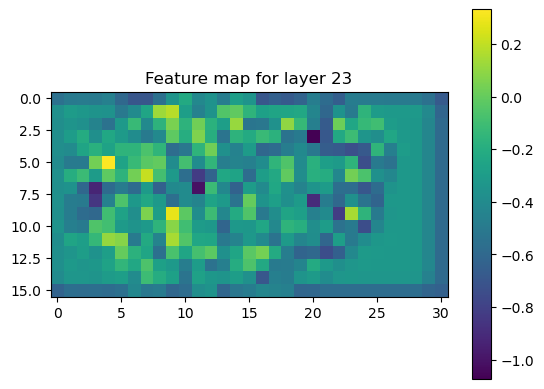

Layer 24 activation stats: min=-46.111671447753906, max=56.376766204833984, mean=-0.07021380960941315


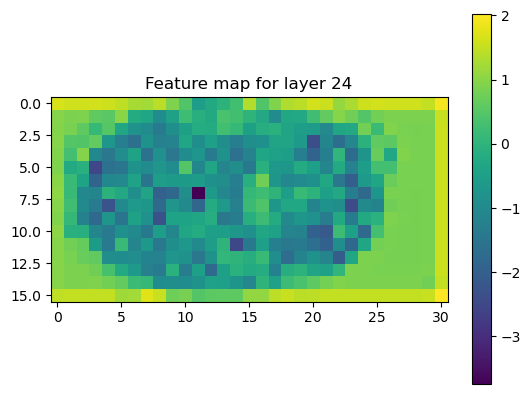

Layer 25 activation stats: min=-0.2782904803752899, max=4.531773567199707, mean=1.357680082321167


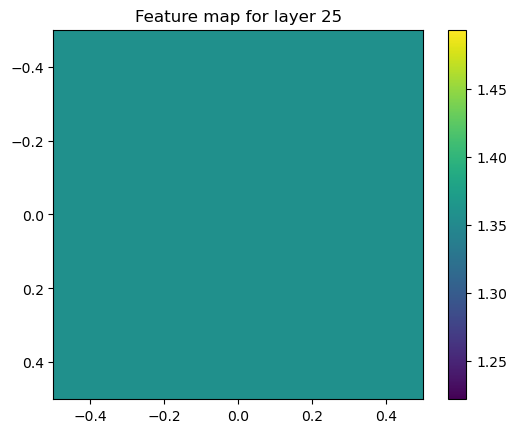

Layer 26 activation stats: min=0.0008249186794273555, max=0.9944297671318054, mean=0.49946632981300354


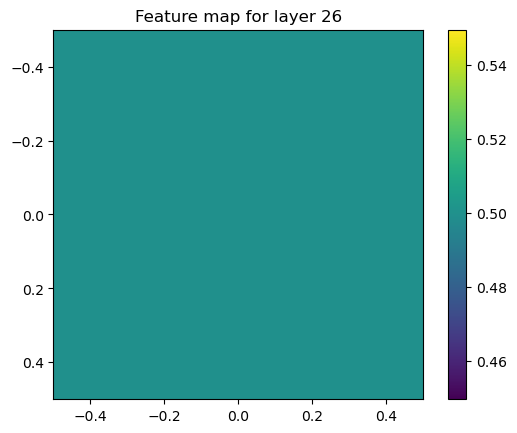

Layer 27 activation stats: min=-27.05503273010254, max=25.63502311706543, mean=0.020442107692360878


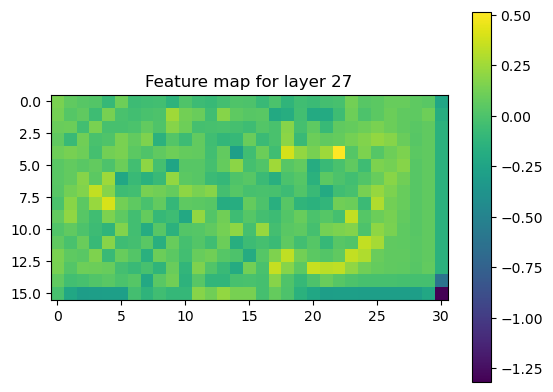

Layer 28 activation stats: min=-73.91323852539062, max=98.17581939697266, mean=-0.7988621592521667


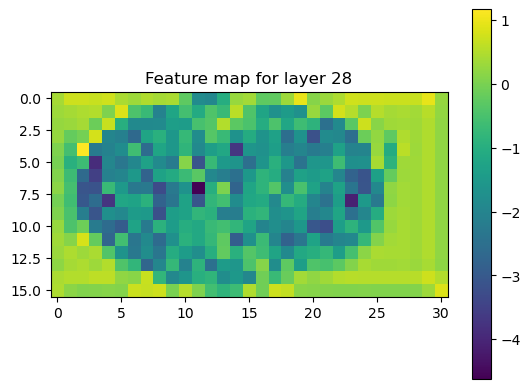

Layer 29 activation stats: min=-0.2783733010292053, max=7.108971118927002, mean=2.154118061065674


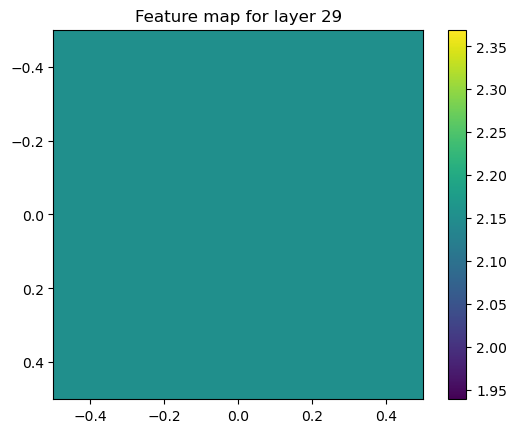

Layer 30 activation stats: min=3.257937351008877e-05, max=0.9995519518852234, mean=0.5240358114242554


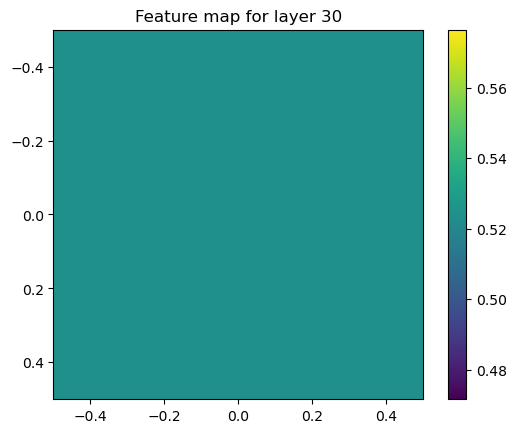

Layer 31 activation stats: min=-29.655704498291016, max=21.761396408081055, mean=-0.07549772411584854


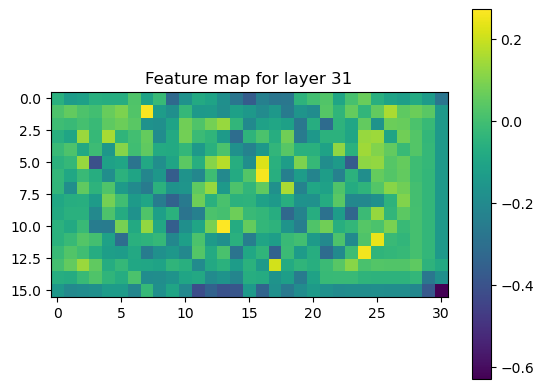

Layer 32 activation stats: min=-136.20803833007812, max=70.43865203857422, mean=-1.6772823333740234


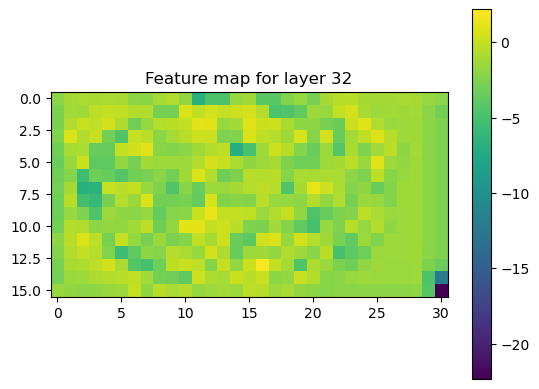

Layer 33 activation stats: min=-0.2559907138347626, max=6.028973579406738, mean=1.6032565832138062


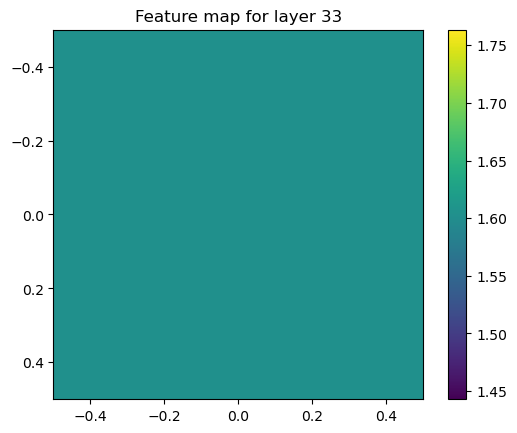

Layer 34 activation stats: min=0.00017071970796678215, max=0.9998365640640259, mean=0.7622883319854736


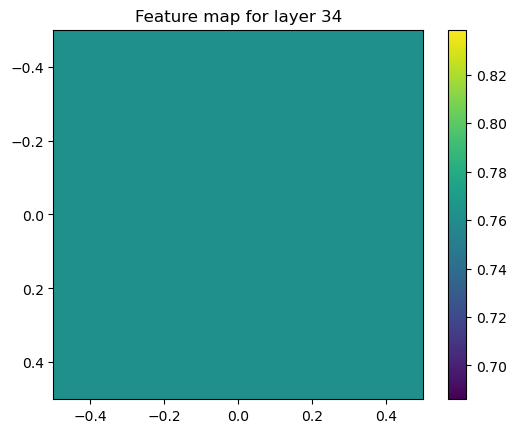

Layer 35 activation stats: min=-14.082881927490234, max=14.92698860168457, mean=0.06397326290607452


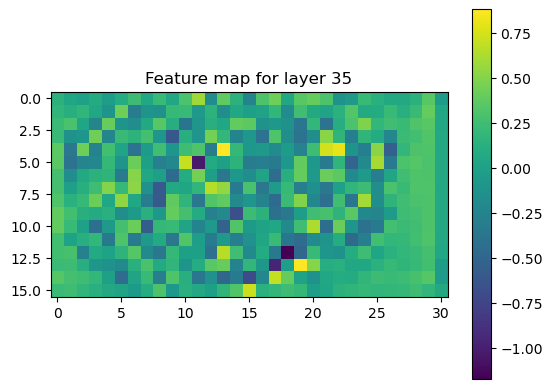

Layer 36 activation stats: min=-52.11763000488281, max=58.051204681396484, mean=-0.0208676066249609


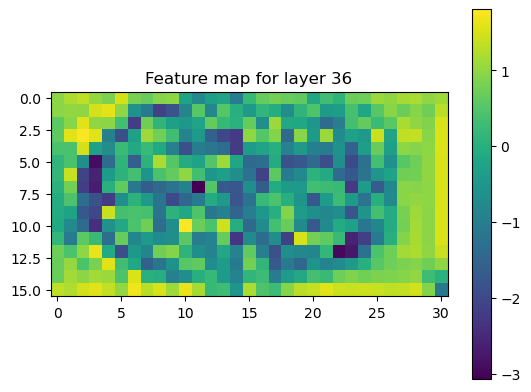

Layer 37 activation stats: min=-0.2558358907699585, max=7.437056541442871, mean=0.864652693271637


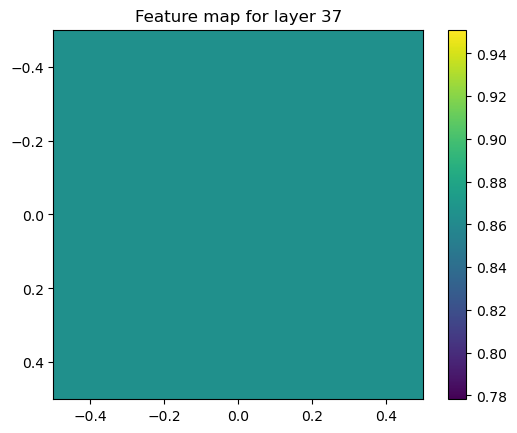

Layer 38 activation stats: min=0.0020047093275934458, max=0.9966536164283752, mean=0.48122596740722656


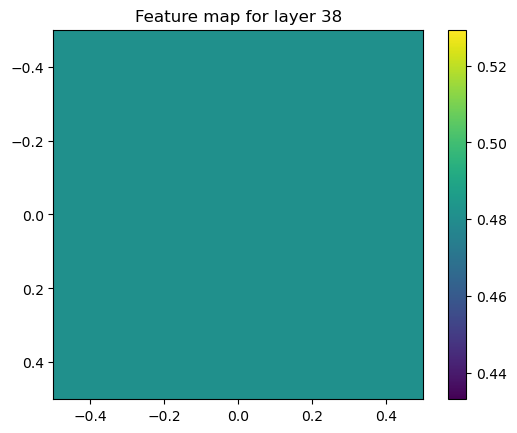

Layer 39 activation stats: min=-16.18003273010254, max=13.2174072265625, mean=-0.03059205412864685


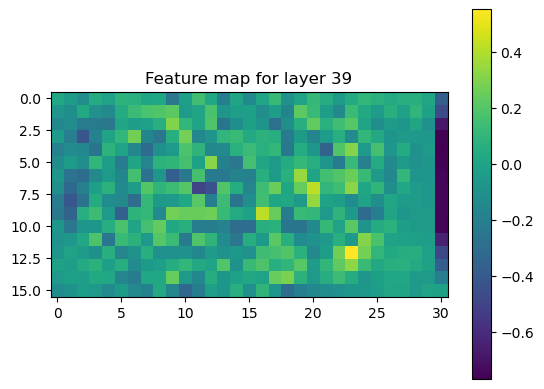

Layer 40 activation stats: min=-54.06644058227539, max=50.67857360839844, mean=-0.9106679558753967


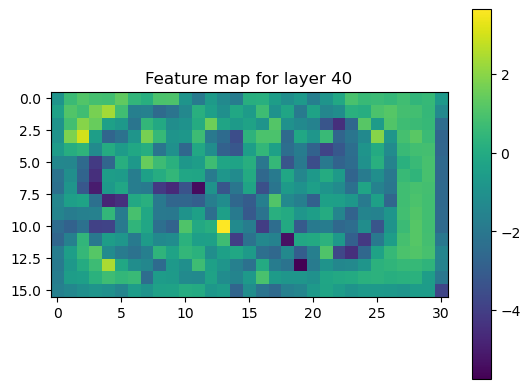

Layer 41 activation stats: min=-0.2784402668476105, max=9.943853378295898, mean=0.9493618607521057


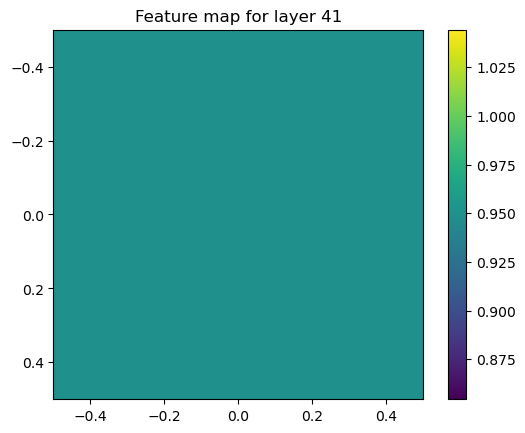

Layer 42 activation stats: min=0.0008134042727760971, max=0.9975478053092957, mean=0.5639646649360657


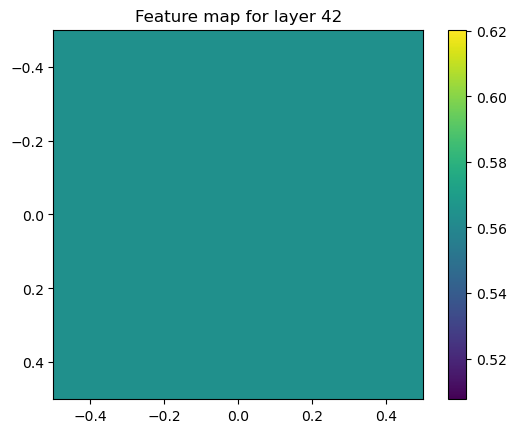

Layer 43 activation stats: min=-14.766356468200684, max=17.348384857177734, mean=0.06857987493276596


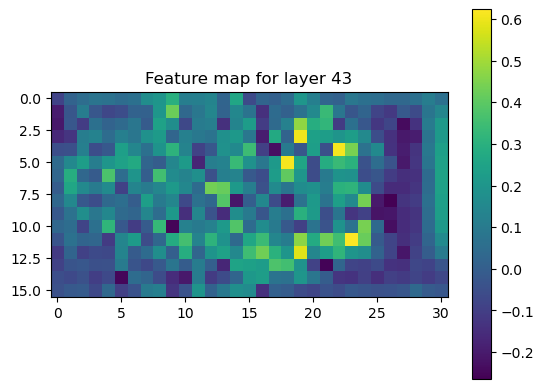

Layer 44 activation stats: min=-69.40739440917969, max=81.34355163574219, mean=-1.2503207921981812


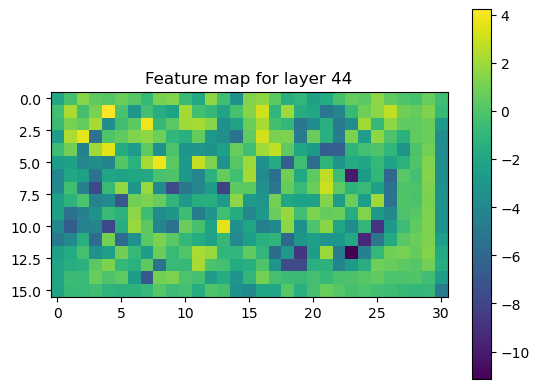

Layer 45 activation stats: min=-0.02901669405400753, max=45.1894645690918, mean=3.8508758544921875


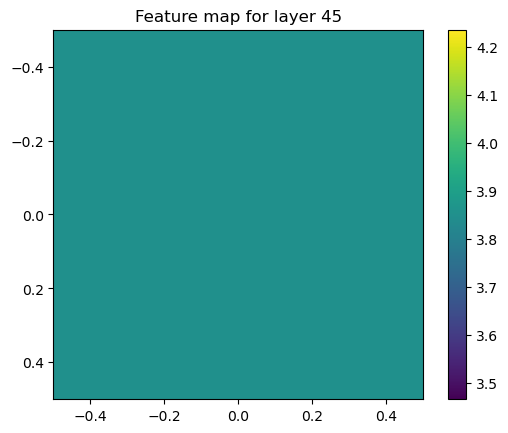

Layer 46 activation stats: min=1.8374006760524253e-09, max=1.0, mean=0.9511153101921082


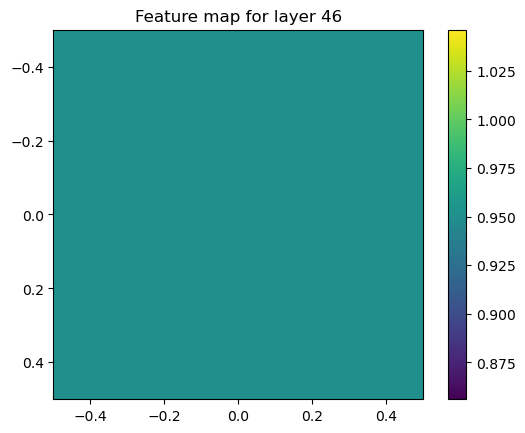

Layer 47 activation stats: min=-24.586217880249023, max=29.615705490112305, mean=-0.15644438564777374


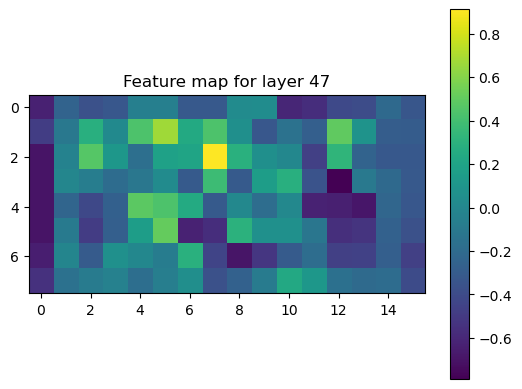

Layer 48 activation stats: min=-64.62287902832031, max=70.57263946533203, mean=-0.18353384733200073


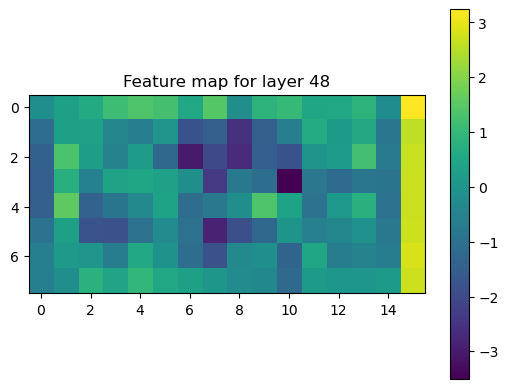

Layer 49 activation stats: min=-0.26574668288230896, max=4.884081840515137, mean=0.5628793239593506


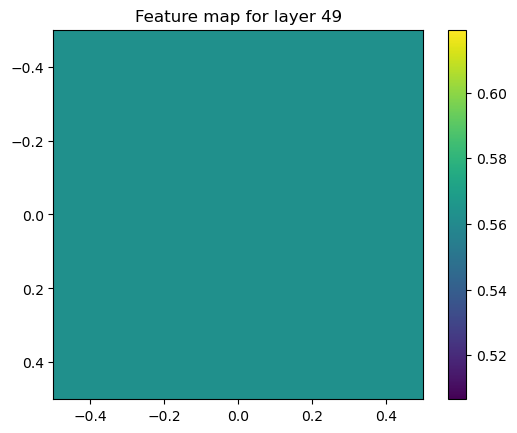

Layer 50 activation stats: min=0.008441023528575897, max=0.9978501796722412, mean=0.3847507834434509


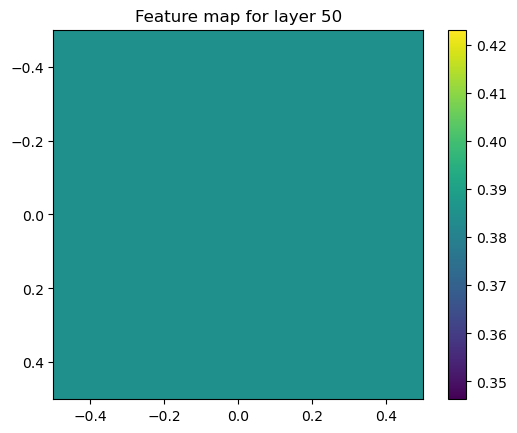

Layer 51 activation stats: min=-46.21803283691406, max=48.72223663330078, mean=-0.057723719626665115


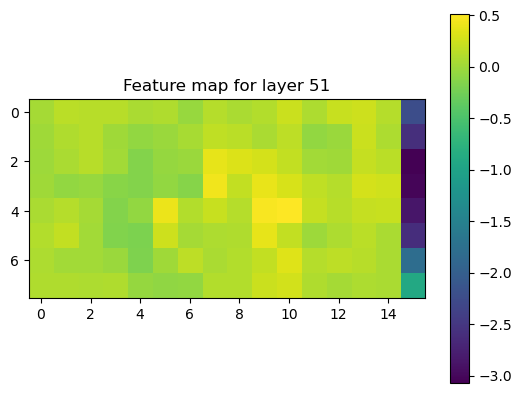

Layer 52 activation stats: min=-67.61444091796875, max=74.2941665649414, mean=-1.0405842065811157


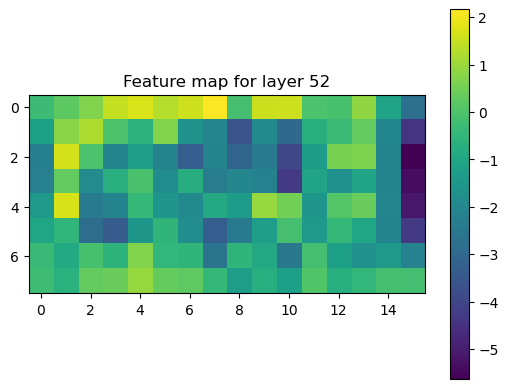

Layer 53 activation stats: min=-0.27833399176597595, max=5.107754707336426, mean=0.7204680442810059


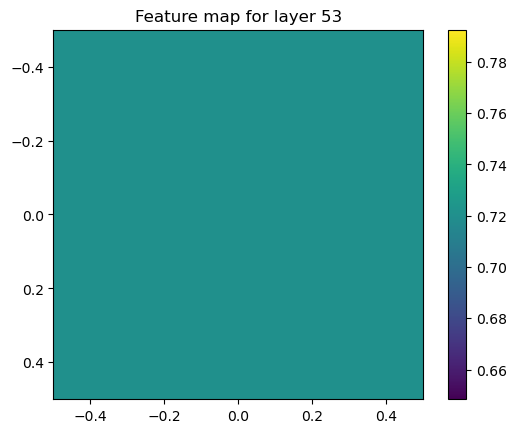

Layer 54 activation stats: min=0.002975062234327197, max=0.9997513890266418, mean=0.37631532549858093


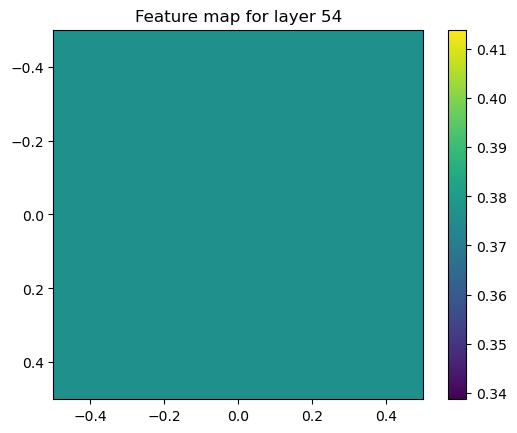

Layer 55 activation stats: min=-40.975711822509766, max=39.415828704833984, mean=0.05292769894003868


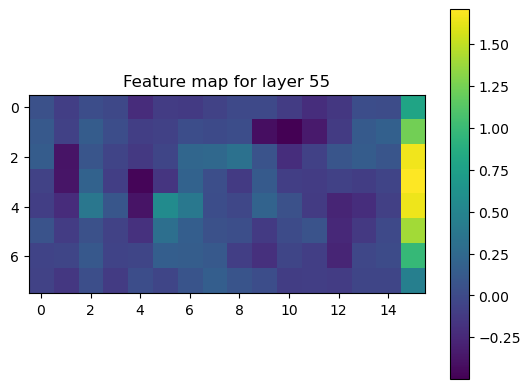

Layer 56 activation stats: min=-112.84735107421875, max=90.53983306884766, mean=-2.1374144554138184


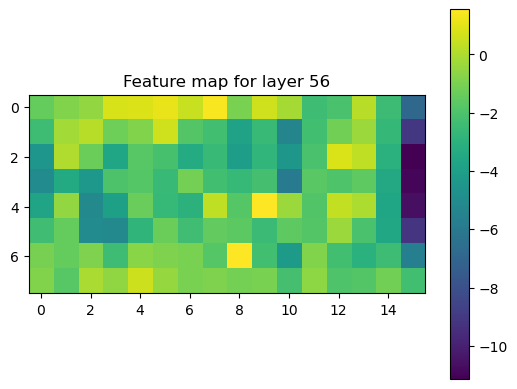

Layer 57 activation stats: min=-0.2672891914844513, max=6.5554518699646, mean=1.0853039026260376


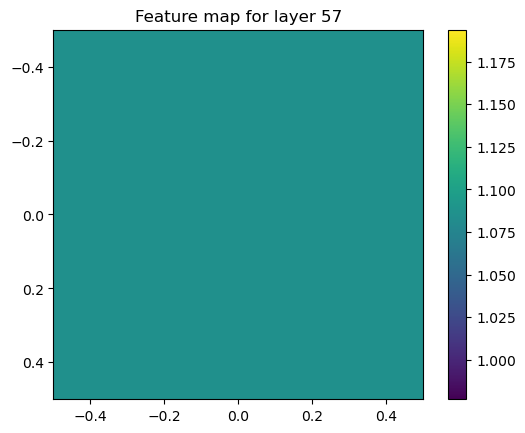

Layer 58 activation stats: min=0.0002065488661173731, max=0.9999675750732422, mean=0.25542742013931274


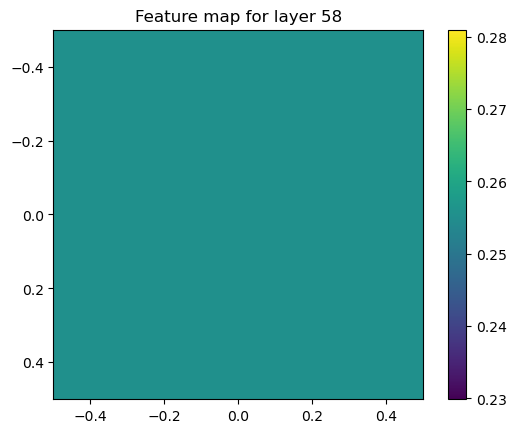

Layer 59 activation stats: min=-46.5610466003418, max=57.78145980834961, mean=-0.09854358434677124


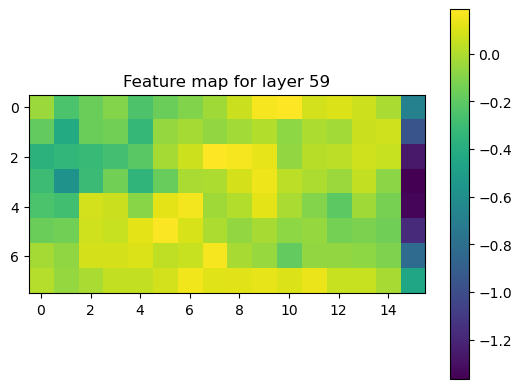

Layer 60 activation stats: min=-118.8910903930664, max=130.7447967529297, mean=-3.273297071456909


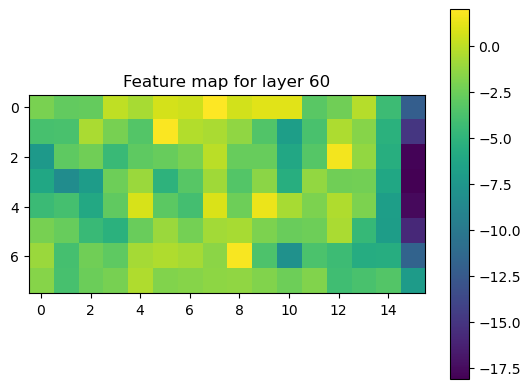

Layer 61 activation stats: min=-0.2776954472064972, max=6.235567569732666, mean=0.32338905334472656


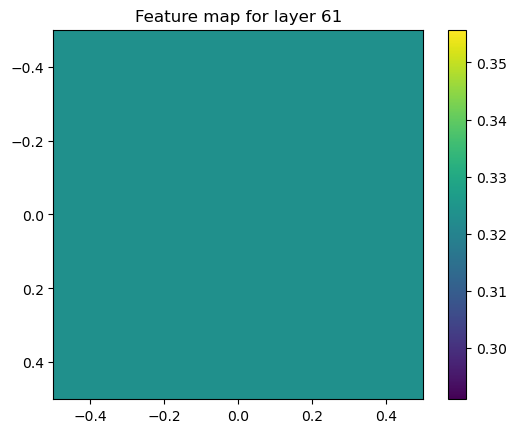

Layer 62 activation stats: min=0.004622746724635363, max=0.9966945648193359, mean=0.4758852422237396


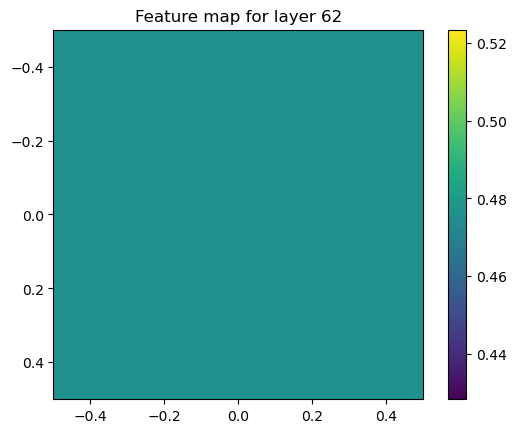

Layer 63 activation stats: min=-17.69459342956543, max=16.299537658691406, mean=0.00754643976688385


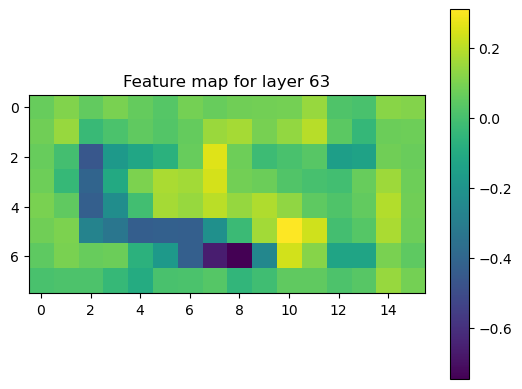

Layer 64 activation stats: min=-54.44692611694336, max=87.31278228759766, mean=-0.22667160630226135


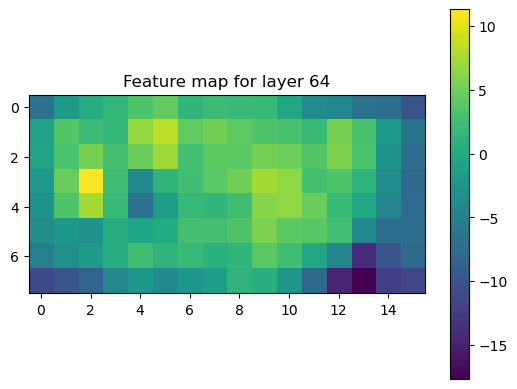

In [36]:
# Assuming you have already predicted activations
for i, activation in enumerate(activations):
    # Just print the raw activation statistics for inspection
    print(f"Layer {i} activation stats: min={np.min(activation)}, max={np.max(activation)}, mean={np.mean(activation)}")

    if np.any(activation):
        # Proceed with visualization if there's any activation
        feature_map = activation[0]  # Assuming a single image in the batch
        heatmap = np.mean(feature_map, axis=-1)
        plt.imshow(heatmap, cmap='viridis')
        plt.title(f"Feature map for layer {i}")
        plt.colorbar()
        plt.show()
    else:
        print(f"Layer {i} activations are all zero.")


In [55]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'Data/oasis_data/Non Demented/OAS1_0001_MR1_mpr-1_135.jpg'
img = image.load_img(img_path, target_size=(248, 496)) 

# Assuming model_EfficientNetB02 is your base model
layer_outputs = [layer.output for layer in model_EfficientNetB02.layers if isinstance(layer, layers.Conv2D)]

# Create a model for displaying the feature maps
feature_map_model = Model(inputs=model_EfficientNetB02.input, outputs=layer_outputs)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 
# Get the feature maps for that single image
feature_maps = feature_map_model.predict(x)

# Plotting the feature maps
for layer_name, feature_map in zip([layer.name for layer in model_EfficientNetB02.layers if isinstance(layer, layers.Conv2D)], feature_maps):
    print(f"Displaying feature maps for layer: {layer_name}")
    num_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * num_features))
    for i in range(num_features):
        # Postprocess the feature to make it visually palatable
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()


1/1 [==============================] - 0s 45ms/step


In [34]:
# One-hot encode the predicted labels
y_pred = to_categorical(y_val, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_val, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_val, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

ValueError: Found input variables with inconsistent numbers of samples: [2018, 8000]